In [1]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.plotting import plot_stat_map, show
from nilearn.plotting import plot_roi, plot_glass_brain
from nilearn.image import clean_img
from nilearn.decoding import SpaceNetClassifier

# Loading the Data

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Obtaining the Mask

Shape of the mask:  (91, 109, 91)


/usr/local/lib/python3.8/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


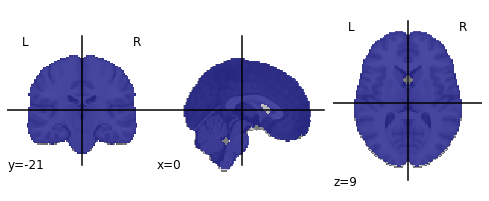

In [4]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy, threshold = .3)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

# Labels

In [5]:
random.seed(42)
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


# Splitting the Test Data

In [6]:
num_subs_for_test = 4
num_imgs_per_sub = 30
beta_maps_test = nib.funcs.concat_images(beta_maps[:num_subs_for_test], axis = -1)
labels_test = labels[:num_imgs_per_sub * num_subs_for_test]

# Splitting the Train Data for CV

In [7]:
labels_train = labels[num_imgs_per_sub * num_subs_for_test:]

beta_maps_train_9sub = nib.funcs.concat_images(beta_maps[num_subs_for_test:], axis = -1)

beta_maps_train_run = beta_maps[num_subs_for_test].slicer[..., :6]

for i in range(5):
    for j in range(45):
        sliced_by_run = beta_maps[j+num_subs_for_test].slicer[..., (i*6):(i*6 + 6)]
        beta_maps_train_run = nib.funcs.concat_images([beta_maps_train_run, sliced_by_run], axis = -1)

beta_maps_train_run = beta_maps_train_run.slicer[..., 6:]

# SpaceNet Classifier - 5fold CV per run

In [9]:
# This is the run for 5fold CV per run!
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=200, # default is 200
                             cv=5,
                             n_jobs=-1,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(beta_maps_train_run, labels_train)

print(getattr(decoder,'cv_'))
print(getattr(decoder,'cv_scores_'))
print(getattr(decoder,'best_model_params_'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 1350),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/usr/local/lib/python3.8/dist-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 14.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f83d44b6e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 457.8s, 7.6min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed: 13.3min remaining: 13.3min


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fa022200e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 574.7s, 9.6min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f866f413e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 598.8s, 10.0min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f7be7a73e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 616.1s, 10.3min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f1c280c2e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 623.4s, 10.4min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fb3d513de50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 641.4s, 10.7min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f7b2abc6e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 644.5s, 10.7min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f396914de50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 647.0s, 10.8min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f1276673e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 687.0s, 11.4min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f053551ee50>, loss='logistic'),

........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.6min finished


Time Elapsed: 1103.01 seconds, 18 minutes.
[(array([ 270,  271,  272, ..., 1347, 1348, 1349]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162,

In [10]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nSpaceNet Classifier (5fold CV per run) test accuracy : %g%%" % accuracy)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 120),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals

SpaceNet Classifier (5fold CV per run) test accuracy : 75%


/usr/local/lib/python3.8/dist-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 1.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


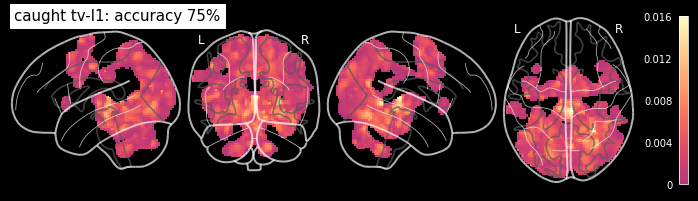

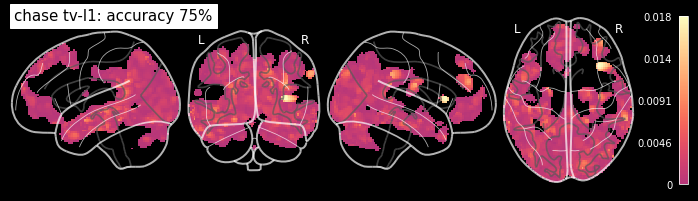

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f08b8afae50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 761.2s, 12.7min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


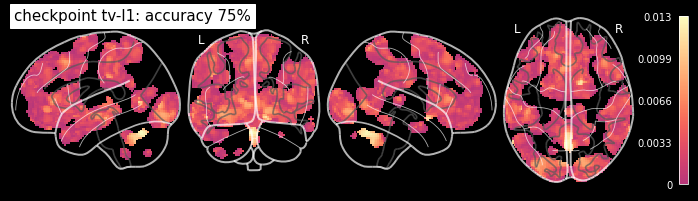

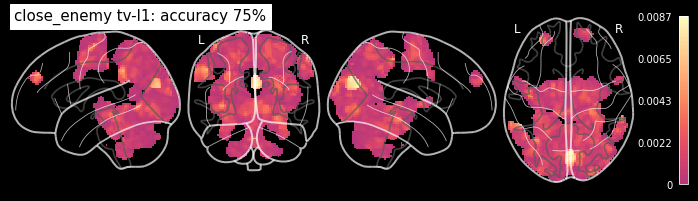

........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 5.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f97bcdcfe50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 762.5s, 12.7min


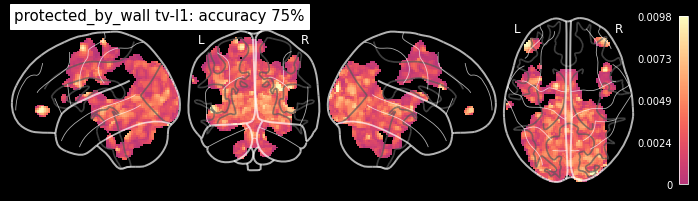

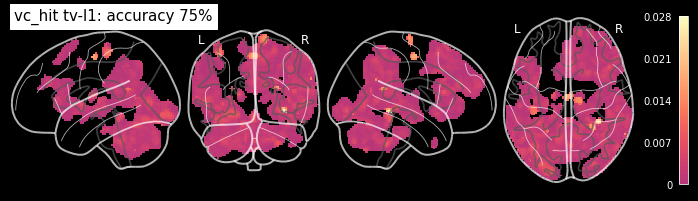

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f9b470f2e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 767.2s, 12.8min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 5.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f8727dc7e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 771.5s, 12.9min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fdd4c641e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 784.8s, 13.1min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fdb96302e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 787.8s, 13.1min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f1a00adde50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 810.9s, 13.5min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f20885e1e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 818.4s, 13.6min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fe8565b6e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 817.8s, 13.6min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fe7efc83e50>, loss='logistic'),

......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f80d0af4e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 832.8s, 13.9min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f3b84652e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 839.3s, 14.0min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f97084bee50>, loss='logistic'),

........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f070703de50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 852.4s, 14.2min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fb65c8dee50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 860.7s, 14.3min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


In [11]:
coef_img = decoder.coef_img_

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' tv-l1: accuracy %g%%' % accuracy)

In [12]:
# This is the run for 5fold CV per run!
decoder = SpaceNetClassifier(penalty='graph-net',
                             mask=mask,
                             max_iter=200, # default is 200
                             cv=5,
                             n_jobs=-1,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(beta_maps_train_run, labels_train)

print(getattr(decoder,'cv_'))
print(getattr(decoder,'cv_scores_'))
print(getattr(decoder,'best_model_params_'))

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f4caa4d4e50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 865.5s, 14.4min


........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.92s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f655e00ae50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 867.6s, 14.5min
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 1350),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0., 

/usr/local/lib/python3.8/dist-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 14.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7fef7dd4ae50>, loss='logistic'), memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 927.3s, 15.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef7dd4aca0>, memmap([[0., ..., 0.],
    

......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
.

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f3d21ba1ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 342.5s, 5.7min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f2eeaf1aca0>, memmap([[0., ..., 0.],
        ...,
        [0., ...,

......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f05c47e3ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 374.6s, 6.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f4ffe87bca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0

........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f962b5d4ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 398.0s, 6.6min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f65e3aceca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
____________________________________________________path_scores - 415.0s, 6.9min


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed: 12.4min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 13.6min finished


Time Elapsed: 873.817 seconds, 14 minutes.
[(array([ 270,  271,  272, ..., 1347, 1348, 1349]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162,

In [13]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
# Return average accuracy
accuracy = (test_pred == labels_test).mean() * 100.
print("\nSpaceNet Classifier (5fold CV per run) test accuracy : %g%%" % accuracy)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(91, 109, 91, 120),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals

SpaceNet Classifier (5fold CV per run) test accuracy : 75.8333%


/usr/local/lib/python3.8/dist-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 1.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


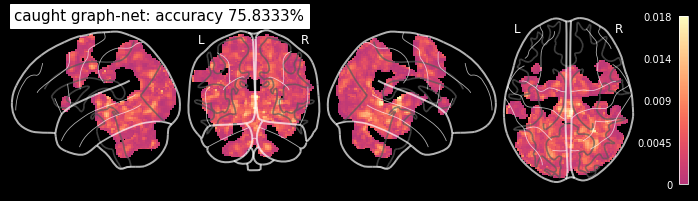

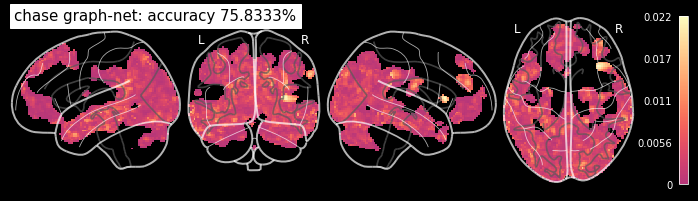

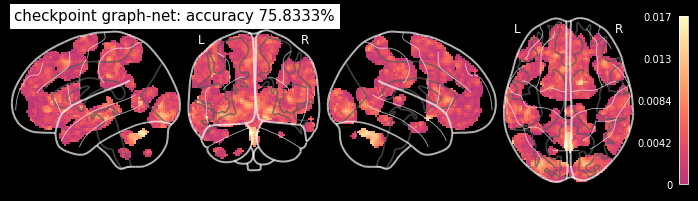

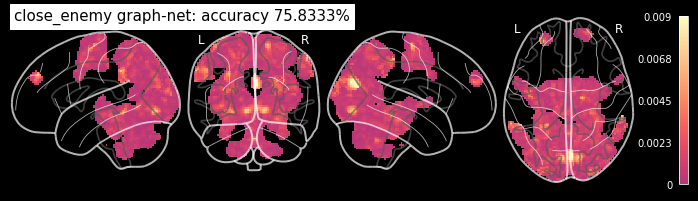

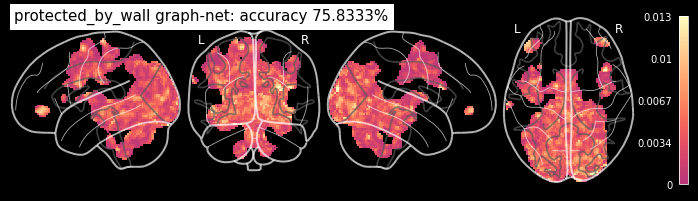

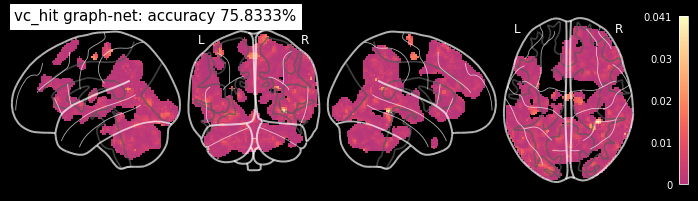

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f7365f4bca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 630.6s, 10.5min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 5.22s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f659650eca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 652.1s, 10.9min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f9f45226e50>, loss='logistic'), memmap([[0., ..., 0.],
    

........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fa800a94ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([ 1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 705.4s, 11.8min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 5.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f5bbffafca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 718.1s, 12.0min


......./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f2ec546bca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 721.1s, 12.0min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7ffa63780ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 722.3s, 12.0min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 4.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f9bdb47cca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 728.3s, 12.1min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f2d3adadca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 737.5s, 12.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f000312ce50>, loss='logistic'), memmap([[0., ..., 0.],
    

........../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fb01d6ceca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 748.4s, 12.5min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fcfcf0d1ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ...,

......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fb172070ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(2, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 757.2s, 12.6min


........./usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fef4d81bca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 761.1s, 12.7min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fdd898e1ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 763.8s, 12.7min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fe656016ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([ 810, ..., 1079]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(3, 3), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 765.1s, 12.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fdc96502ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ...,

......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)
......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f5d9c790ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 769.2s, 12.8min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.77s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fb23654fca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1079]), array([1080, ..., 1349]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 4), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 772.1s, 12.9min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f8dce3cfca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 774.3s, 12.9min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f88e88bdca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 270, ..., 1349]), array([  0, ..., 269]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(4, 0), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 779.8s, 13.0min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.73s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7f0e35113ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ..., -1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([540, ..., 809]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(1, 2), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 793.8s, 13.2min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_logistic at 0x7fb2044a5ca0>, memmap([[0., ..., 0.],
        ...,
        [0., ..., 0.]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([   0, ..., 1349]), array([270, ..., 539]), {'max_iter': 200, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(5, 1), debias=False, verbose=1, screening_percentile=19.547639832085963)
___________________________________________________path_scores - 800.7s, 13.3min


......../usr/local/lib/python3.8/dist-packages/joblib/parallel.py:262: UserWarning: Persisting input arguments took 3.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return [func(*args, **kwargs)


In [15]:
coef_img = decoder.coef_img_

conditions = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']
for i, condition in enumerate(conditions):
    plot_glass_brain(coef_img.slicer[...,i], black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title=condition + ' graph-net: accuracy %g%%' % accuracy)